In [5]:
# -*- coding: Paper1 -*-
"""
This code belongs to the paper:
-- An Iterative Gradient Descent-Based Reinforcement Learning Policy 
   for Active Control of Structural Vibrations, Computers & Structures.
-- Jagajyoti Panda, Mudit Chopra, Vasant Matsagar, Souvik Chakraborty, IIT Delhi.
   
This code is to present the robust performance of trained RL controllers in P and PI feedback.
-- Case study II: 8-story benchmark building (section 5.2.2)
"""
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import os
from numpy import abs as Abs
from numpy import sign as sign
from numpy import sqrt,pi,array
from scipy import signal
 
 
import matplotlib
import matplotlib.pyplot as plt

from control.matlab import *  # MATLAB-like functions
import control as ct
 
import tensorflow as tf
from gym import Env
from gym.spaces import Discrete, Box
 
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [6]:
GMdt = np.loadtxt('GMdt.txt', unpack = True)
print(len(GMdt))

60


In [7]:
# Proportional Controller (8storey)
BKt = np.load('BKt_P8.npy')
Ad = np.load('Ad_P8.npy')
Bd = np.load('Bd_P8.npy')
Cd1 = np.load('Cd1_P8.npy')
Cd = np.load('Cd_P8.npy')
Dd = np.load('Dd_P8.npy')
Ed = np.load('Ed_P8.npy')
Kpo = np.load('Kpo_P8.npy')
print(BKt)

[[-1.07895273e-04 -2.14393736e-04 -3.12562478e-04 -4.00091059e-04
  -4.74017252e-04 -5.31796932e-04 -5.71452555e-04 -5.91550470e-04
   6.70918372e-06  1.13622354e-05  1.41018314e-05  1.32146395e-05
   1.14791339e-05  9.04526455e-06  6.88212879e-06  3.30314582e-07]
 [-2.14363476e-04 -4.21683399e-04 -6.14704337e-04 -7.86935762e-04
  -9.32297310e-04 -1.04593795e-03 -1.12393311e-03 -1.16346206e-03
   1.37481959e-05  2.30035781e-05  2.84270755e-05  2.67027338e-05
   2.32960412e-05  1.85125462e-05  1.42602158e-05  1.37509654e-06]
 [-3.12564058e-04 -6.14730969e-04 -8.95123989e-04 -1.14823283e-03
  -1.35914636e-03 -1.52480440e-03 -1.63851084e-03 -1.69613773e-03
   2.01749395e-05  3.37379146e-05  4.16869550e-05  3.93690248e-05
   3.44191373e-05  2.74477887e-05  2.12499655e-05  2.46619953e-06]
 [-4.00087967e-04 -7.86909115e-04 -1.14823270e-03 -1.46735689e-03
  -1.73970608e-03 -1.95186498e-03 -2.09737172e-03 -2.17113677e-03
   2.59120726e-05  4.33221339e-05  5.34871448e-05  5.00800038e-05
   4.37

In [10]:
# PI Controller (8storey)
BKti = np.load('BKt_PI8.npy')
FI = np.load('FI_PI8.npy')
gI = np.load('gI_PI8.npy')
Cd1i = np.load('Cd1_PI8.npy')
Cdi = np.load('Cdi_PI8.npy')
Ddi = np.load('Ddi_PI8.npy')
BIrd = np.load('Ed_PI8.npy')
Kpoi = np.load('Kpo_PI8.npy')
print(BKti)

[[ 5.29505677e-07  1.38049543e-06  2.30160224e-06  3.03255699e-06
   3.64783431e-06  4.24184955e-06  4.57265266e-06  4.74094418e-06
  -5.09028618e-07 -9.21653120e-07 -1.23644844e-06 -1.46602771e-06
  -1.62684968e-06 -1.71874836e-06 -1.77618837e-06 -1.76007643e-06
  -3.93487570e-05 -1.38403839e-04 -1.83611742e-04]
 [ 1.74115084e-06  3.44726507e-06  5.06882425e-06  6.50451933e-06
   7.71446004e-06  8.66688720e-06  9.31773939e-06  9.64786874e-06
   1.19275769e-07  2.23897743e-07  3.18064858e-07  4.31159989e-07
   5.30760092e-07  6.16954436e-07  6.81882274e-07  8.02563239e-07
  -7.54285669e-05 -2.70903797e-04 -3.60481077e-04]
 [ 2.28909359e-06  4.78145806e-06  7.70244875e-06  9.78127784e-06
   1.15606035e-05  1.28711718e-05  1.38206054e-05  1.43017189e-05
   4.69680410e-07  9.88358102e-07  1.56105742e-06  2.08093094e-06
   2.49594337e-06  2.80746256e-06  3.02609554e-06  3.26418578e-06
  -1.10687512e-04 -3.94165802e-04 -5.25002785e-04]
 [ 3.59478417e-06  6.79061589e-06  9.17839996e-06  1.18

In [11]:
no = np.linalg.norm(Bd@Kpo)
noi = np.linalg.norm(gI@Kpoi)
print(no, noi)

0.07705200956499841 0.09091104840580905


In [12]:
npg = np.linalg.norm(BKt)
npgi = np.linalg.norm(BKti)
print(npg, npgi)

0.01378206840305955 0.015984526335633267


In [13]:
# Proposed controller (inv(B)@BKt)
Kpt = (np.linalg.pinv(Bd)@BKt)
Kpti = (np.linalg.pinv(gI)@BKti)
print(Kpt.shape, Kpti.shape)

(3, 16) (3, 19)


In [14]:
n = 8
r =3
Qp = np.identity(2*n)
Qpi = np.identity(2*n+r)
print(Qpi.shape)

(19, 19)


In [15]:
# Trained results
xr = np.zeros([4100, 2*n, len(GMdt)])  # State
yr = np.zeros([4100, len(Cd1), len(GMdt)])  # output
xri = np.zeros([4100, 2*n+r, len(GMdt)])  # State
yri = np.zeros([4100, len(Cd1i), len(GMdt)])  # output
# Optimal results
xo = np.zeros([4100, 2*n, len(GMdt)])
xoi = np.zeros([4100, 2*n+r, len(GMdt)])
xu= np.zeros([4100, 2*n, len(GMdt)])
(i,j) = Cd.shape
yu = np.zeros([4100, i, len(GMdt)])
yo = np.zeros([4100, i, len(GMdt)])
yoi = np.zeros([4100, i, len(GMdt)])

In [16]:
J1r = np.zeros([len(GMdt), n])
J2r = np.zeros([len(GMdt), n])
J3r = np.zeros([len(GMdt), n])
J4r = np.zeros([len(GMdt), 1])
J5r = np.zeros([len(GMdt), 3])
J1o = np.zeros([len(GMdt), n])
J2o = np.zeros([len(GMdt), n])
J3o = np.zeros([len(GMdt), n])
J4o = np.zeros([len(GMdt), 1])
J5o = np.zeros([len(GMdt), 3])

In [17]:
J1ri = np.zeros([len(GMdt), n])
J2ri = np.zeros([len(GMdt), n])
J3ri = np.zeros([len(GMdt), n])
J4ri = np.zeros([len(GMdt), 1])
J5ri = np.zeros([len(GMdt), 3])
J1oi = np.zeros([len(GMdt), n])
J2oi = np.zeros([len(GMdt), n])
J3oi = np.zeros([len(GMdt), n])
J4oi = np.zeros([len(GMdt), 1])
J5oi = np.zeros([len(GMdt), 3])

In [18]:
Euct = np.zeros([4100, 1, len(GMdt)]) 
Eot = np.zeros([4100, 1, len(GMdt)])  
Et = np.zeros([4100, 1, len(GMdt)]) 
Fot = np.zeros([4100, r, len(GMdt)])  
Ft = np.zeros([4100, r, len(GMdt)]) 

In [19]:
Eoti = np.zeros([4100, 1, len(GMdt)])  
Eti = np.zeros([4100, 1, len(GMdt)]) 
Foti = np.zeros([4100, r, len(GMdt)])  
Fti = np.zeros([4100, r, len(GMdt)]) 

la49.dat
[-0.010823000000000001 -0.011333 -0.011715 ... -0.018123 -0.019209
 -0.01822]


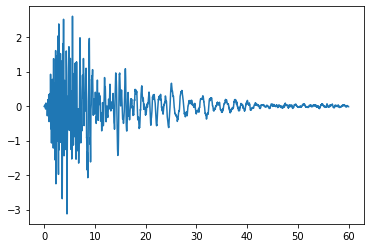

la50.dat
[-0.0015623 -0.001663 0.0001207 ... -0.0069499 -0.0055411 -0.0062433]


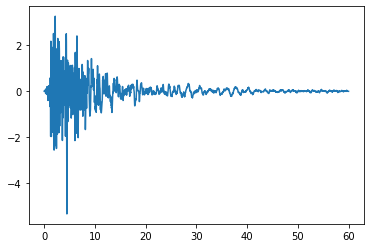

la51.dat
[0.0019339000000000001 0.028081000000000002 0.042504999999999994 ... 0.0
 0.0 0.0]


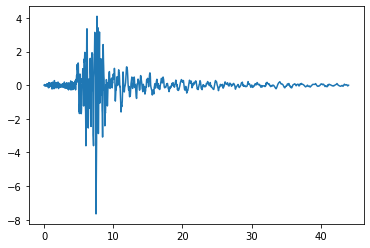

la52.dat
[-0.02091 0.016228 0.025797 ... 0.0 0.0 0.0]


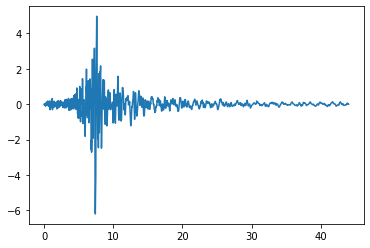

la53.dat
[-0.052344 -0.16985 0.00033269 ... -0.0013858000000000002 0.032789 0.0786]


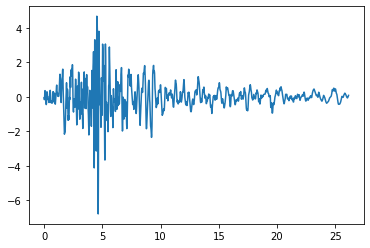

la54.dat
[0.0063604 0.11373 0.0063855 ... -0.17533 -0.1868 -0.19794]


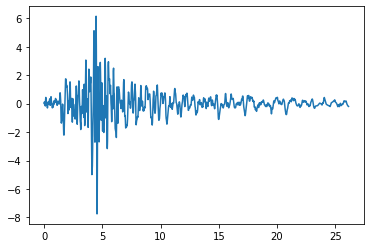

la55.dat
[-0.00021517999999999998 -0.0057355999999999996 0.018000000000000002 ...
 0.04463 0.044263000000000004 0.019961]


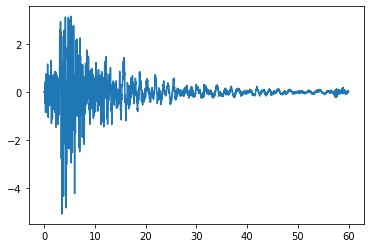

la56.dat
[-0.0008376599999999999 0.0032708999999999998 0.019704 ... 0.048518 0.1152
 -0.0086838]


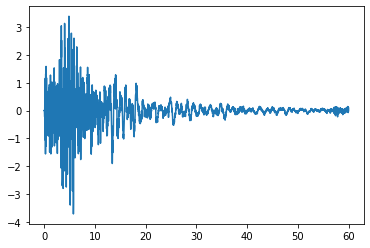

la57.dat
[0.013127999999999999 0.018644 -0.08732799999999999 ... 0.0 0.0 0.0]


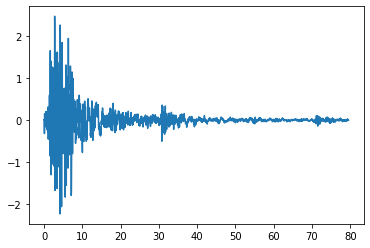

la58.dat
[0.14169 0.099291 0.028331 ... 0.0 0.0 0.0]


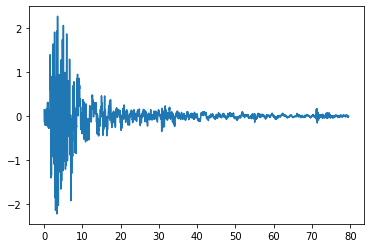

la59.dat
[-0.097903 -0.08815300000000001 -0.037705999999999996 ... 0.0 0.0 0.0]


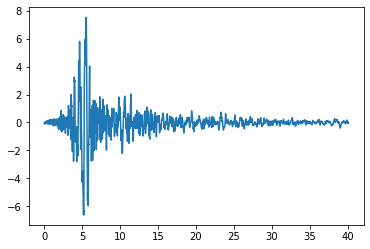

la60.dat
[-0.12971 -0.068386 -0.051687000000000004 ... 0.0 0.0 0.0]


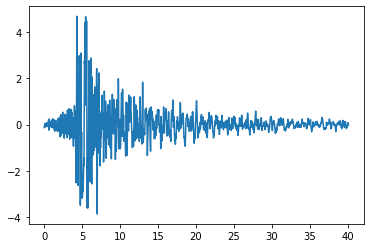

In [21]:
# Ground motion input
for ijk in range(49,len(GMdt)+1):
    if ijk < 10:
        filename="la0" + str(ijk) + ".dat"
        print(filename)
    else:
        filename="la" + str(ijk) + ".dat"
        print(filename)
     
    data = np.loadtxt(filename, unpack = True)

    xacc=np.full([len(data)*len(data[0])],None)
    for x in range(len(data[0])):
        for y in range(len(data)):
            if x == 0:
                xacc[y] = data[y, x]
            else:
                xacc[y+(x*6)] = data[y, x]
    xacc = xacc/100
    print(xacc)
    # 
    # Time series for ground motion
    dt = GMdt[ijk-1]
    tend = dt*len(xacc)
    tim = np.arange(0, tend, dt)
    plt.figure()
    plt.plot(tim,xacc)
    plt.show(block=False)
    for tkk in range(0,len(tim)-1):
        time_current = tim[tkk]
        h = xacc[tkk] 
        xn = np.array([xr[tkk,:,ijk-1]]).T
        xn1 = (Ad @ xn) + (BKt @ xn) + (Ed * h)
        #     print(xn1)
        xr[tkk+1,:,ijk-1] = xn1.T
        En2 = 0.5*((xn1.T @ Qp)@ (xn1))
        Et[tkk+1,:,ijk-1] = En2
        Fn2 = Kpt @ xn1
        Ft[tkk+1,:,ijk-1] = Fn2.T
        yn1 = (Cd1-BKt) @ xn1
        yr[tkk+1,:,ijk-1] = yn1.T
        del xn, xn1, En2, Fn2, yn1
        # print(sinewave)
        
        y = (Cd @ np.array([xu[tkk,:,ijk-1]]).T)
        yu[tkk,:,ijk-1] = y.T
        x = (Ad @ np.array([xu[tkk,:,ijk-1]]).T) + (Ed * h)
        xu[tkk+1,:,ijk-1] = x.T
        En1 = 0.5*((x.T @ Qp)@ (x))
        Euct[tkk+1,:,ijk-1] = En1
        del y, x, En1
        
        y1 = (Cd @ np.array([xo[tkk,:,ijk-1]]).T) + (Dd @ ((-1*Kpo) @ np.array([xo[tkk,:,ijk-1]]).T))
        yo[tkk,:,ijk-1] = y1.T
        x1 = (Ad @ np.array([xo[tkk,:,ijk-1]]).T) + (Bd @ ((-1*Kpo) @ np.array([xo[tkk,:,ijk-1]]).T)) + (Ed * h)
        xo[tkk+1,:,ijk-1] = x1.T
        En0 = 0.5*((x1.T @ Qp)@ (x1))
        Eot[tkk+1,:,ijk-1] = En0
        Fn1 = Kpo @ x1
        Fot[tkk+1,:,ijk-1] = Fn1.T
        del y1, x1, En0, Fn1 
        
        ## PI controller
        xn = np.array([xri[tkk,:,ijk-1]]).T
        xn1 = (FI @ xn) + (BKti @ xn) + (BIrd * h)
#         print(xn1)
        xri[tkk+1,:,ijk-1] = xn1.T
        En2 = 0.5*((xn1.T @ Qpi)@ (xn1))
        Eti[tkk+1,:,ijk-1] = En2
        Fn2 = Kpti @ xn1
        Fti[tkk+1,:,ijk-1] = Fn2.T
        yn1 = (Cd1i-BKti) @ xn1
        yri[tkk+1,:,ijk-1] = yn1.T
        del xn, xn1, En2, Fn2, yn1
        
        y1 = (Cdi @ np.array([xoi[tkk,:,ijk-1]]).T) + (Ddi @ ((-1*Kpoi) @ np.array([xoi[tkk,:,ijk-1]]).T))
        yoi[tkk,:,ijk-1] = y1.T
        x1 = (FI @ np.array([xoi[tkk,:,ijk-1]]).T) + (gI @ ((-1*Kpoi) @ np.array([xoi[tkk,:,ijk-1]]).T)) + (BIrd * h)
        xoi[tkk+1,:,ijk-1] = x1.T
#         print(Qpi)
        En0 = 0.5*((x1.T @ Qpi)@ (x1))
        Eoti[tkk+1,:,ijk-1] = En0
        Fn1 = Kpoi @ x1
        Foti[tkk+1,:,ijk-1] = Fn1.T
        del y1, x1, En0, Fn1 
        
# Performance indices   
    for i in range(0,n):
        J1r[ijk-1, i] = max(xr[:,i,ijk-1], key=abs)/max(xu[:,i,ijk-1], key=abs)
        J1o[ijk-1, i] = max(xo[:,i,ijk-1], key=abs)/max(xu[:,i,ijk-1], key=abs)
        J2r[ijk-1, i] = max(xr[:,n+i,ijk-1], key=abs)/max(xu[:,n+i,ijk-1], key=abs)
        J2o[ijk-1, i] = max(xo[:,n+i,ijk-1], key=abs)/max(xu[:,n+i,ijk-1], key=abs)
        J3r[ijk-1, i] = max(yr[:,i,ijk-1], key=abs)/max(yu[:,i,ijk-1], key=abs)
        J3o[ijk-1, i] = max(yo[:,i,ijk-1], key=abs)/max(yu[:,i,ijk-1], key=abs)
        
        J1ri[ijk-1, i] = max(xri[:,i,ijk-1], key=abs)/max(xu[:,i,ijk-1], key=abs)
        J1oi[ijk-1, i] = max(xoi[:,i,ijk-1], key=abs)/max(xu[:,i,ijk-1], key=abs)
        J2ri[ijk-1, i] = max(xri[:,n+i,ijk-1], key=abs)/max(xu[:,n+i,ijk-1], key=abs)
        J2oi[ijk-1, i] = max(xoi[:,n+i,ijk-1], key=abs)/max(xu[:,n+i,ijk-1], key=abs)
        J3ri[ijk-1, i] = max(yri[:,i,ijk-1], key=abs)/max(yu[:,i,ijk-1], key=abs)
        J3oi[ijk-1, i] = max(yoi[:,i,ijk-1], key=abs)/max(yu[:,i,ijk-1], key=abs)
        
    J4r[ijk-1, 0] = max(Et[:,:,ijk-1], key=abs)/max(Euct[:,:,ijk-1], key=abs)
    J4o[ijk-1, 0] = max(Eot[:,:,ijk-1], key=abs)/max(Euct[:,:,ijk-1], key=abs)
    J4r[ijk-1, 0] = max(Et[:,:,ijk-1], key=abs)/max(Euct[:,:,ijk-1], key=abs)
    J4o[ijk-1, 0] = max(Eot[:,:,ijk-1], key=abs)/max(Euct[:,:,ijk-1], key=abs)
    for i in range(0,r):
        J5r[ijk-1, i] = (max(Ft[:,i,ijk-1], key=abs)*(npg*10/no))/(345600*10*8)
        J5o[ijk-1, i] = max(Fot[:,i,ijk-1], key=abs)/(345600*10*8)
        J5ri[ijk-1, i] = (max(Fti[:,i,ijk-1], key=abs)*(npg*10/no))/(345600*10*8)
        J5oi[ijk-1, i] = max(Foti[:,i,ijk-1], key=abs)/(345600*10*8)

In [27]:
Floor = [1, 2, 3, 4, 5, 6, 7, 8]
print("J1 - Proposed P:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J1r)
PJ1 = np.zeros([len(GMdt), 1]) 
for ijk in range(0,len(GMdt)):
    PJ1[ijk,:] = max(np.absolute(J1r[ijk,:]))
PJ1[46:56] = PJ1[48:58]

J1 - Proposed P:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[-0.43341059  0.42594212  0.42851954 -0.43131268 -0.42883086 -0.42680042
  -0.42436241 -0.42214823]
 [-0.65980744 -0.64581195 -0.63105419 -0.6201986  -0.62715599 -0.65642908
  -0.68571308  0.70177971]
 [ 0.61672149  0.61138002  0.60536733  0.59851139  0.5939025   0.59798172
   0.60943429  0.61749479]
 [ 0.47953283 -0.48174559 -0.48050716  0.47691859  0.48007109  0.48090156
   0.48038349 -0.48156229]
 [-0.61527222 -0.63309827 -0.65778868 -0.68208151 -0.70284153 -0.71771626
  -0.72702364 -0.73135675]
 [-0.84211992 -0.82215347 -0.80935699 -0.80492398  0.79959564  0.78518237
   0.77612498  0.77205839]
 [ 0.82765276  0.77112064  0.70623212  0.64353993  0.59142197  0.55763424
   0.54410298  0.54138084]
 [ 0.59330406  0.54101445  0.49613909  0.49535095  0.49442999  0.49353455
   0.50643735  0.52711721]
 [-0.49123279  0.50856996  0.54483629  0.59341079  0.64621569  0.69465439
  

In [28]:
import numpy as np
import scipy.stats as st
  
# define sample data
gfg_data10 = PJ1[0:20,0]
gfg_data2 = PJ1[20:40,0]
gfg_data50 = PJ1[40:57,0]  
# create 95% confidence interval (hazard level - 10% in 50 years)
print(np.mean(gfg_data10))
st.t.interval(alpha=0.95, df=len(gfg_data10)-1,
              loc=np.mean(gfg_data10),
              scale=st.sem(gfg_data10))

0.7075018570803203


(0.6456892874869263, 0.7693144266737143)

In [21]:
# create 95% confidence interval (hazard level - 2% in 50 years)
print(np.mean(gfg_data2))
st.t.interval(alpha=0.95, df=len(gfg_data2)-1,
              loc=np.mean(gfg_data2),
              scale=st.sem(gfg_data2))

0.7286794704784417


(0.677875286279952, 0.7794836546769315)

In [22]:
# create 95% confidence interval (hazard level - 50% in 50 years)
print(np.mean(gfg_data50))
st.t.interval(alpha=0.95, df=len(gfg_data50)-1,
              loc=np.mean(gfg_data50),
              scale=st.sem(gfg_data50))

0.6474348932491827


(0.5795729885507058, 0.7152967979476595)

In [408]:
Floor = [1, 2, 3, 4, 5, 6, 7, 8]
print("J1 - Proposed PI:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J1ri)
PJ1i = np.zeros([len(GMdt), 1]) 
for ijk in range(0,len(GMdt)):
    PJ1i[ijk,:] = max(np.absolute(J1ri[ijk,:]))
PJ1i[46:56] = PJ1i[48:58]

J1 - Proposed PI:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[ 0.31765161  0.31276199  0.31395605 -0.31904229 -0.32132441 -0.32247709
  -0.32224408 -0.32127889]
 [ 0.46919632  0.47196784  0.46360459  0.44695516  0.42688238  0.43328528
   0.46920389 -0.48803894]
 [-0.41233948 -0.39650597 -0.38246458 -0.36990919 -0.35957866 -0.35116522
  -0.34517503 -0.34197424]
 [ 0.48701847  0.48452129  0.49116287  0.49571486  0.49310133  0.48571686
   0.47723248  0.47182275]
 [ 0.61948097  0.61750919  0.61492354  0.61172663  0.60802687  0.60412173
   0.60085712  0.59903573]
 [ 0.64316396  0.64888392  0.64558061  0.63783068 -0.62310922 -0.60194035
  -0.59108916 -0.58800819]
 [-0.62678478  0.58631521  0.54008381 -0.49975792 -0.50403154 -0.52369164
  -0.54506447 -0.55810464]
 [ 0.70967332  0.67235311  0.63397111  0.59702632  0.56980697  0.55299204
   0.55988001  0.56784451]
 [ 1.15626099  1.15568189  1.14595909  1.13306906  1.12502699  1.1210475
  

In [411]:
# define sample data
gfg_data10 = PJ1i[0:20,0]
gfg_data2 = PJ1i[20:40,0]
gfg_data50 = PJ1i[40:57,0]  
# create 95% confidence interval
print(np.mean(gfg_data10))
st.t.interval(alpha=0.95, df=len(gfg_data10)-1,
              loc=np.mean(gfg_data10),
              scale=st.sem(gfg_data10))

0.7396459623555279


(0.5924114235032931, 0.8868805012077627)

In [412]:
print(np.mean(gfg_data2))
st.t.interval(alpha=0.95, df=len(gfg_data2)-1,
              loc=np.mean(gfg_data2),
              scale=st.sem(gfg_data2))

0.7223321342227287


(0.6172890409897095, 0.8273752274557479)

In [413]:
print(np.mean(gfg_data50))
st.t.interval(alpha=0.95, df=len(gfg_data50)-1,
              loc=np.mean(gfg_data50),
              scale=st.sem(gfg_data50))

0.6649975319700664


(0.569582939394606, 0.7604121245455268)

In [414]:
print("J1 - Optimal P:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J1o)
PJ1o = np.zeros([len(GMdt), 1]) 
for ijk in range(0,len(GMdt)):
    PJ1o[ijk,:] = max(np.absolute(J1o[ijk,:]))
PJ1o[46:56] = PJ1o[48:58]

J1 - Optimal P:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[ 0.78035093  0.78366503 -0.79128502  0.79140309  0.78660307  0.78221738
   0.78086526  0.78105796]
 [ 0.88925326  0.89336073  0.89503551  0.89263126  0.89252339 -0.89505066
  -0.92774041  0.94488004]
 [ 0.91011863  0.90938153  0.90899534  0.90800239  0.90766026  0.9074498
   0.90734388  0.90789188]
 [ 0.83467378  0.83279885  0.83116757  0.83046157  0.82971144  0.82984193
   0.82981476  0.83002435]
 [ 0.89102229  0.8938139   0.89443201  0.8929226   0.89108091 -0.90486779
  -0.91603525 -0.92141108]
 [ 0.92005973 -0.92544548 -0.93178483 -0.94402829  0.95722502  0.95339974
   0.95133871  0.95038867]
 [ 0.93617534  0.89578937  0.84368087  0.83550289  0.83168976  0.82760039
   0.82449766  0.82303863]
 [ 0.83242066  0.83778818  0.84039059  0.83972601  0.84026337  0.84015517
   0.84039999  0.84052001]
 [ 0.7791114   0.7818238   0.78276132  0.78133711  0.78109182  0.78024659
   0

In [416]:
# define sample data
gfg_data10 = PJ1o[0:20,0]
gfg_data2 = PJ1o[20:40,0]
gfg_data50 = PJ1o[40:57,0]  
# create 95% confidence interval
print(np.mean(gfg_data10))
st.t.interval(alpha=0.95, df=len(gfg_data10)-1,
              loc=np.mean(gfg_data10),
              scale=st.sem(gfg_data10))

0.90729200109452


(0.8782710299781633, 0.9363129722108767)

In [417]:
print(np.mean(gfg_data2))
st.t.interval(alpha=0.95, df=len(gfg_data2)-1,
              loc=np.mean(gfg_data2),
              scale=st.sem(gfg_data2))

0.9329020407773623


(0.9161159463114031, 0.9496881352433214)

In [418]:
print(np.mean(gfg_data50))
st.t.interval(alpha=0.95, df=len(gfg_data50)-1,
              loc=np.mean(gfg_data50),
              scale=st.sem(gfg_data50))

0.8999526998166828


(0.8764000040023661, 0.9235053956309995)

In [420]:
print("J1 - Optimal PI:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J1oi)
PJ1oi = np.zeros([len(GMdt), 1]) 
for ijk in range(0,len(GMdt)):
    PJ1oi[ijk,:] = max(np.absolute(J1oi[ijk,:]))
PJ1oi[46:56] = PJ1oi[48:58]

J1 - Optimal PI:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[ 0.70194745  0.70920254 -0.72241369  0.6988427   0.68639064  0.66652293
   0.65621265  0.65146687]
 [ 0.83346749  0.84548507  0.8493969   0.83934007  0.83451482  0.82405813
  -0.85326481  0.87101896]
 [ 0.81444526  0.83909277  0.84588063  0.83450131  0.83773324  0.83451445
   0.84185445  0.84797544]
 [-0.71959917 -0.72698472 -0.73532623 -0.73982263 -0.74396055 -0.7459105
  -0.74849122 -0.74996189]
 [ 0.86243361  0.84473455 -0.84093704 -0.86881966 -0.8899033  -0.90482261
  -0.91318241 -0.91654782]
 [ 0.97867938  0.93097108  0.91253365  0.92747968 -0.91549322 -0.91063679
  -0.91124887 -0.91558113]
 [ 0.9046911   0.88961447  0.84024497  0.76521098  0.75912788  0.75403853
   0.75239385  0.75189363]
 [ 0.73350716  0.75646519  0.76299891  0.75540944  0.75752372  0.75463355
   0.75541584  0.75576391]
 [ 0.66079136  0.6743738   0.67710465  0.67006788  0.70728015  0.75231833
   

In [422]:
# define sample data
gfg_data10 = PJ1oi[0:20,0]
gfg_data2 = PJ1oi[20:40,0]
gfg_data50 = PJ1oi[40:57,0]  
# create 95% confidence interval
print(np.mean(gfg_data10))
st.t.interval(alpha=0.95, df=len(gfg_data10)-1,
              loc=np.mean(gfg_data10),
              scale=st.sem(gfg_data10))

0.8752608124719774


(0.8370877715947023, 0.9134338533492525)

In [423]:
print(np.mean(gfg_data2))
st.t.interval(alpha=0.95, df=len(gfg_data2)-1,
              loc=np.mean(gfg_data2),
              scale=st.sem(gfg_data2))

0.8951393908330594


(0.8686818670029074, 0.9215969146632114)

In [424]:
print(np.mean(gfg_data50))
st.t.interval(alpha=0.95, df=len(gfg_data50)-1,
              loc=np.mean(gfg_data50),
              scale=st.sem(gfg_data50))

0.848767764359917


(0.8103806707040343, 0.8871548580157996)

In [426]:
print("J2 - Proposed P:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J2r)
PJ2 = np.zeros([len(GMdt), 1]) 
for ijk in range(0,len(GMdt)):
    PJ2[ijk,:] = max(np.absolute(J2r[ijk,:]))
PJ2[46:56] = PJ2[48:58]

J2 - Proposed P:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[ 0.52739123  0.51687282  0.49723106  0.47822138  0.42461037  0.42686306
   0.46336429  0.48655162]
 [ 0.91656032  0.89456714  0.80695345 -0.83008197 -0.80534578  0.60604258
   0.63497211  0.64877933]
 [ 0.70841842  0.69547304 -0.67146885 -0.67055326 -0.68005502  0.69261162
   0.69481937  0.69584504]
 [ 0.7126644   0.61084127  0.50940915  0.50097485  0.52066629  0.55960257
   0.5745873   0.57832823]
 [-0.66474778 -0.65609228 -0.69751114 -0.72957003 -0.77305054 -0.81613162
  -0.84770506 -0.86473906]
 [ 0.88346006  0.86184916 -0.82963707  0.78578232  0.78412277  0.78655576
   0.78774307  0.78836108]
 [ 0.9310152   0.91750132  0.80048683  0.65961842  0.55908248  0.57836098
   0.64273652 -0.7213725 ]
 [ 0.92545289  0.93213314 -0.88511561 -0.81749908 -0.84017789 -0.90916348
   0.93852016  0.94273405]
 [ 1.01060236  1.00908346  0.98576465  0.9126875   0.85910067  0.87673333
  

In [370]:
print("J2 - Proposed PI:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J2ri)

J2 - Proposed PI:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[ 0.46971138  0.48681127  0.50137137  0.51536436 -0.45218377 -0.38469078
  -0.33709852  0.33785645]
 [ 1.08278541  1.0878602   1.01525486  0.88594556  0.70491644 -0.44226766
   0.53244135  0.5837294 ]
 [ 0.45909416  0.41272935  0.38892838  0.39974068  0.41303408 -0.42239238
  -0.41960824 -0.41726685]
 [ 0.80317954  0.7726463   0.72536288  0.66192297  0.60535088  0.57452884
   0.56121742  0.55506885]
 [-1.02428614 -1.0376148  -1.02653411 -0.9894309  -0.96762784 -0.94414322
  -0.92070034 -0.9122881 ]
 [ 0.77707112  0.71211858 -0.66447561 -0.60181771 -0.55470347 -0.52451907
  -0.50771692 -0.50083845]
 [ 0.87403663  0.9056136  -0.77318554  0.64950017  0.54921518  0.54212676
   0.60159375  0.63652642]
 [ 0.82848918  0.94408339 -0.8437715  -0.67449608  0.65293119  0.74119791
  -0.79599563 -0.81970362]
 [ 1.13505477  1.10448036  1.02906979  0.94420806  0.96605941  0.97895039
 

In [371]:
print("J2 - Optimal P:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J2o)

J2 - Optimal P:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[ 0.80803196  0.82000612  0.81854809  0.80776952  0.7949023   0.8098673
   0.81911438  0.82573742]
 [ 0.94678408  0.92835821  0.91956312  0.92285974  0.9128354   0.91785551
   0.92052804  0.921593  ]
 [-0.84415732  0.86024481 -0.87585677 -0.88467207 -0.9132845   0.92617114
   0.92546427  0.92548603]
 [-0.8384812  -0.83938199 -0.83004397  0.83461841  0.82900805  0.82023821
   0.8229301   0.82431719]
 [ 0.86861339  0.89831358  0.93454616  0.93425162  0.93486826  0.93712878
   0.93952326  0.94159827]
 [ 0.93622367  0.97754589  0.98581568  0.97183402  0.96700178  0.96329337
   0.96205556  0.96126632]
 [ 0.90954661  0.93177281  0.81762342  0.81320299  0.81417436 -0.81228523
  -0.81235287 -0.81251225]
 [ 0.92813566  0.9472973  -0.93501204 -0.85751609 -0.89383608 -0.96621965
   0.99320148  0.99233419]
 [ 0.91224143  0.98618568  0.98803815  0.91256349  0.87304746  0.89605247
   0

In [372]:
print("J2 - Optimal PI:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J2oi)

J2 - Optimal PI:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[-0.67189558  0.68973103  0.70811995  0.7078356   0.71129468  0.73630133
   0.75713777  0.77360721]
 [ 0.88637866  0.85119554  0.86079293 -0.84231243  0.89929758  0.88875485
   0.88158074  0.88140023]
 [-0.86837354 -0.87043793 -0.87065353 -0.8479156  -0.87415364  0.87698062
   0.87605587  0.87553554]
 [-0.7629148  -0.77948732  0.78717064  0.7822845   0.77996643  0.74687938
   0.71715258  0.71844277]
 [ 0.81710727  0.89596304  0.93245686  0.92108565  0.92074231  0.92085951
   0.93048611  0.9382101 ]
 [ 0.93919681  1.03791995 -1.04342728  0.95289427  0.95617025  0.94643485
   0.94886934  0.95095992]
 [ 0.81709291  0.91689948  0.87842958  0.74976315  0.75216996 -0.74632728
   0.75679402  0.81746221]
 [ 0.78810359  0.97183826 -1.03222874 -0.88091048 -0.89963189 -0.97324159
   1.00185942  1.00490007]
 [-0.7787623   1.02218346  1.06516549  0.93820413  0.88875266  0.88094296
  

In [441]:
print("J3 - Proposed P:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J3r)
PJ3 = np.zeros([len(GMdt), 1]) 
for ijk in range(0,len(GMdt)):
    PJ3[ijk,:] = np.absolute(J3r[ijk,7])
PJ3[46:56] = PJ3[48:58]

J3 - Proposed P:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[ 0.9049392   0.78529733  0.68833809  0.60379159  0.51743895  0.45760857
   0.46084977  0.53538262]
 [ 0.99414814  0.99500542  1.00269135  0.92444657  0.79030107  0.76663437
   0.78318214  0.78770041]
 [-0.95030205  0.74783002  0.72293946  0.68928662  0.63038262  0.62449475
   0.76678498  0.79366601]
 [ 0.98460344  1.03059207  1.04607527 -0.94753694  0.68669886  0.53665921
  -0.70831036 -0.85268776]
 [ 0.9596957   0.91760746  0.74522042  0.69969424  0.74910541  0.79214
   0.79096366  0.79484629]
 [ 1.05349129 -0.95427058 -0.76065126 -0.71236825 -0.70182353 -0.73625688
  -0.83482733  0.83891918]
 [ 0.97628261  0.95118145  0.99253377  0.97881326 -0.91426372  0.65030672
   0.82191379 -0.86252023]
 [ 1.02007864  0.94764024  0.92463935  0.88440344 -0.73546926  0.74601348
   0.9753444   0.98134346]
 [ 1.00137372  1.01774777  1.03543667 -0.99073145 -0.6829553  -0.85849983
   0.

In [442]:
# define sample data
gfg_data10 = PJ3[0:20,0]
gfg_data2 = PJ3[20:40,0]
gfg_data50 = PJ3[40:57,0]  
# create 95% confidence interval
print(np.mean(gfg_data10))
st.t.interval(alpha=0.95, df=len(gfg_data10)-1,
              loc=np.mean(gfg_data10),
              scale=st.sem(gfg_data10))

0.8417454824937941


(0.7807666796153276, 0.9027242853722606)

In [443]:
# create 95% confidence interval
print(np.mean(gfg_data2))
st.t.interval(alpha=0.95, df=len(gfg_data2)-1,
              loc=np.mean(gfg_data2),
              scale=st.sem(gfg_data2))

0.7774211323483764


(0.7202542360527188, 0.834588028644034)

In [444]:
# create 95% confidence interval
print(np.mean(gfg_data50))
st.t.interval(alpha=0.95, df=len(gfg_data50)-1,
              loc=np.mean(gfg_data50),
              scale=st.sem(gfg_data50))

0.7726728805142421


(0.7278628063342762, 0.817482954694208)

In [446]:
print("J3 - Proposed PI:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J3ri)
PJ3i = np.zeros([len(GMdt), 1]) 
for ijk in range(0,len(GMdt)):
    PJ3i[ijk,:] = np.absolute(J3ri[ijk,7])
PJ3i[46:56] = PJ3i[48:58]

J3 - Proposed PI:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[ 0.78691205  0.62401941  0.53773497  0.45212672  0.39818144  0.36751635
   0.47114237  0.55008129]
 [ 0.95353732  0.94266786  0.96757745  0.90609527  0.66045213 -0.57217326
   0.68755861 -0.9354908 ]
 [ 1.08722107  0.67749594 -0.50977501 -0.42733831 -0.38282075  0.31859797
  -0.35406014 -0.38893041]
 [ 0.9510209   1.01610346  1.03326536 -0.877101    0.67129651 -0.56518622
  -0.63285987 -0.79888305]
 [ 0.93875343  0.94502313  0.73915813 -0.61277699  0.62954481 -0.55174761
  -0.4957779  -0.48825062]
 [ 1.16284509 -1.01199164  0.89300986  0.82935245  0.7244433  -0.5636698
  -0.70485776  0.7806752 ]
 [ 0.95410915  0.906067   -0.94285708 -0.96336848  0.8842034  -0.65808376
  -0.8944051   0.95634437]
 [ 1.0846469   0.89529779  0.68908859 -0.73632399 -0.87305771  0.83875557
  -1.01265207 -0.93189372]
 [ 1.09737484  1.27942926  1.48082502 -1.60138573  1.33357087  1.20793548
  

In [447]:
# define sample data
gfg_data10 = PJ3i[0:20,0]
gfg_data2 = PJ3i[20:40,0]
gfg_data50 = PJ3i[40:57,0]  
# create 95% confidence interval
print(np.mean(gfg_data10))
st.t.interval(alpha=0.95, df=len(gfg_data10)-1,
              loc=np.mean(gfg_data10),
              scale=st.sem(gfg_data10))

0.8690124966723355


(0.7311057093139284, 1.0069192840307426)

In [448]:
# create 95% confidence interval
print(np.mean(gfg_data2))
st.t.interval(alpha=0.95, df=len(gfg_data2)-1,
              loc=np.mean(gfg_data2),
              scale=st.sem(gfg_data2))

0.7770148484259348


(0.6925121844842692, 0.8615175123676004)

In [449]:
# create 95% confidence interval
print(np.mean(gfg_data50))
st.t.interval(alpha=0.95, df=len(gfg_data50)-1,
              loc=np.mean(gfg_data50),
              scale=st.sem(gfg_data50))

0.7915669046428802


(0.6879439633732796, 0.8951898459124807)

In [450]:
print("J3 - Optimal P:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J3o)
PJ3o = np.zeros([len(GMdt), 1]) 
for ijk in range(0,len(GMdt)):
    PJ3o[ijk,:] = np.absolute(J3o[ijk,7])
PJ3o[46:56] = PJ3o[48:58]

J3 - Optimal P:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[ 0.96129167  0.92764369  0.91830462  0.84785254  0.84934619  0.80629979
   0.80686552  0.82945395]
 [ 1.00620579  1.00331968  1.04356362  0.94517432  0.96001929  0.93059767
   0.95209306  0.95572953]
 [-0.96206166  0.92357822  0.92910838  0.90682426  0.9176106   0.89754049
   0.94870064  0.95039165]
 [ 1.00385698  0.97177193  0.96938243 -0.95581962 -0.83991577  0.82716648
   0.84279699  0.84970661]
 [ 0.99507779  0.99606785  0.95609318  0.90788885  0.93438865  0.95563071
   0.95830815  0.95769901]
 [ 1.01910219 -0.97865288  0.95105055  0.90947149  0.92480531  0.92199097
  -0.97001211  0.99022632]
 [ 1.0052211   0.9388701   0.98932418  0.97453662 -0.93906553  0.82039975
   0.93085805  0.92320441]
 [ 1.03664152  0.97058126  1.00216979  0.97677109  0.85206138  0.83744633
   0.97203114  1.00154457]
 [ 1.01421507  0.99154351  1.00213182 -0.94576019  0.82867627 -0.95880239
   

In [451]:
# define sample data
gfg_data10 = PJ3o[0:20,0]
gfg_data2 = PJ3o[20:40,0]
gfg_data50 = PJ3o[40:57,0]  
# create 95% confidence interval
print(np.mean(gfg_data10))
st.t.interval(alpha=0.95, df=len(gfg_data10)-1,
              loc=np.mean(gfg_data10),
              scale=st.sem(gfg_data10))

0.9497694392091915


(0.9269912654610388, 0.9725476129573443)

In [452]:
# create 95% confidence interval
print(np.mean(gfg_data2))
st.t.interval(alpha=0.95, df=len(gfg_data2)-1,
              loc=np.mean(gfg_data2),
              scale=st.sem(gfg_data2))

0.9414043111243948


(0.9258281509730439, 0.9569804712757457)

In [453]:
# create 95% confidence interval
print(np.mean(gfg_data50))
st.t.interval(alpha=0.95, df=len(gfg_data50)-1,
              loc=np.mean(gfg_data50),
              scale=st.sem(gfg_data50))

0.9205264267013341


(0.9014309491760641, 0.9396219042266041)

In [455]:
print("J3 - Optimal PI:\n", "    Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 \n     Floor7      Floor8 \n", J3oi)
PJ3oi = np.zeros([len(GMdt), 1]) 
for ijk in range(0,len(GMdt)):
    PJ3oi[ijk,:] = np.absolute(J3oi[ijk,7])
PJ3oi[46:56] = PJ3oi[48:58]

J3 - Optimal PI:
     Floor1      Floor2      Floor3     Floor4      Floor5       Floor6 
     Floor7      Floor8 
 [[ 1.02087675  0.9387241   0.97509389  0.78249248  0.83973272  0.75191749
   0.69143632  0.73562038]
 [ 1.10242922  1.04127456  1.37813405  1.17743793  1.04282352  0.85089745
   0.90061346  0.91511845]
 [ 1.07523406  0.91259724  0.91048694  0.87346115  0.88136348  0.84680411
   0.99011483  0.98536053]
 [ 1.10412431  1.0291989   1.02118679 -1.04342393  0.83475877  0.75931627
   0.7849965  -0.83497405]
 [ 1.08445096  1.04369712  1.00618125  0.8812519   0.94615623  0.93766217
   0.9313516   0.91475982]
 [ 1.15265665 -1.02239477  0.97521968  0.83188695  0.88718388 -0.90962468
  -1.01208135  1.01434395]
 [ 1.16321438  0.99624778  1.13225732  1.07575412  0.97877057  0.76291289
   0.91067822  0.90777773]
 [ 1.21566066  1.01700645  1.15589835  1.05985867 -0.88538351  0.82796377
   1.03934223  1.06303711]
 [ 1.12251036  1.0523983   1.14930929 -1.09442594  0.7859452  -0.98171374
  

In [456]:
# define sample data
gfg_data10 = PJ3oi[0:20,0]
gfg_data2 = PJ3oi[20:40,0]
gfg_data50 = PJ3oi[40:57,0]  
# create 95% confidence interval
print(np.mean(gfg_data10))
st.t.interval(alpha=0.95, df=len(gfg_data10)-1,
              loc=np.mean(gfg_data10),
              scale=st.sem(gfg_data10))

0.9681017022146555


(0.921279128859913, 1.014924275569398)

In [457]:
# create 95% confidence interval
print(np.mean(gfg_data2))
st.t.interval(alpha=0.95, df=len(gfg_data2)-1,
              loc=np.mean(gfg_data2),
              scale=st.sem(gfg_data2))

0.9309214196578391


(0.8971585980382719, 0.9646842412774064)

In [458]:
# create 95% confidence interval
print(np.mean(gfg_data50))
st.t.interval(alpha=0.95, df=len(gfg_data50)-1,
              loc=np.mean(gfg_data50),
              scale=st.sem(gfg_data50))

0.9186613116914037


(0.8757900632095126, 0.9615325601732949)

In [345]:
print("J4 - Proposed P:\n", J4r)

J4 - Proposed P:
 [[0.18572069]
 [0.37417056]
 [0.47515888]
 [0.28308819]
 [0.65631869]
 [0.61939975]
 [0.31494841]
 [0.79384424]
 [0.72245151]
 [0.70714115]
 [0.37977628]
 [0.91623008]
 [0.78585397]
 [0.63074558]
 [0.62773978]
 [0.63453595]
 [0.26218419]
 [0.64551645]
 [1.08580986]
 [0.6107932 ]
 [0.68872186]
 [0.66266402]
 [0.84307352]
 [0.39031348]
 [0.6277359 ]
 [0.63452169]
 [0.2621836 ]
 [0.64551881]
 [0.52395179]
 [0.42823864]
 [0.28254987]
 [0.3678017 ]
 [0.26150635]
 [0.36455444]
 [0.55919663]
 [0.63051328]
 [0.41039237]
 [0.59028504]
 [0.76058567]
 [0.44511869]
 [0.51661319]
 [0.23477864]
 [0.6563206 ]
 [0.61939463]
 [0.35146113]
 [0.36376248]
 [0.        ]
 [0.        ]
 [0.48226956]
 [0.35248768]
 [0.34262364]
 [0.76617749]
 [0.42013579]
 [0.44281457]
 [0.85102378]
 [0.31886304]
 [0.29854528]
 [0.26046301]
 [1.06798224]
 [1.00145226]]


In [ ]:
print("J4 - Proposed PI:\n", J4ri)

In [330]:
print("J4 - Optimal:\n", J4o)

J4 - Optimal:
 [[0.65388677]
 [0.84250755]
 [0.8586926 ]
 [0.67541142]
 [0.87741226]
 [0.92987978]
 [0.65978319]
 [0.8836278 ]
 [0.7562345 ]
 [0.92788285]
 [0.82585062]
 [0.96681112]
 [0.86654409]
 [0.89732543]
 [0.94772398]
 [0.82455837]
 [0.76038852]
 [0.88783663]
 [1.01373895]
 [0.78358611]
 [0.95163396]
 [0.91903775]
 [0.84383814]
 [0.81266615]
 [0.94772331]
 [0.82453793]
 [0.76038818]
 [0.88783647]
 [0.8261357 ]
 [0.75957705]
 [0.73239477]
 [0.8124882 ]
 [0.77648707]
 [0.78988959]
 [0.86135005]
 [0.90134413]
 [0.77336049]
 [0.80493479]
 [0.96014024]
 [0.87535434]
 [0.88636043]
 [0.70985499]
 [0.87741147]
 [0.92987772]
 [0.82351943]
 [0.86264824]
 [0.        ]
 [0.        ]
 [0.87012045]
 [0.79497591]
 [0.8307297 ]
 [0.94936081]
 [0.75811822]
 [0.8719943 ]
 [0.89095857]
 [0.74625997]
 [0.81426931]
 [0.57663434]
 [1.01535323]
 [1.00994897]]


In [40]:
print("J5 - proposed:\n", J5ri)
PJ5o = np.zeros([len(GMdt), 1]) 
for ijk in range(0,len(GMdt)):
    PJ5o[ijk,:] = np.absolute(J5ri[ijk,0])+np.absolute(J5ri[ijk,1])+np.absolute(J5ri[ijk,2])
PJ5o[46:56] = PJ5o[48:58]

J5 - proposed:
 [[ 0.0020647   0.00168356 -0.00089367]
 [ 0.00189766  0.00174181  0.00097583]
 [-0.00351372 -0.00344493 -0.00199031]
 [-0.00369555 -0.00339433 -0.00190102]
 [-0.00477157 -0.00446797 -0.00252895]
 [-0.00240388 -0.0024737  -0.0014501 ]
 [ 0.00153685  0.00159701  0.00094028]
 [-0.0017889  -0.00170408 -0.00097028]
 [ 0.00254588  0.00214778  0.00135141]
 [ 0.00216379  0.00193322  0.00109785]
 [-0.00240925 -0.00220232 -0.00123183]
 [-0.00179008 -0.00162316 -0.00090449]
 [ 0.0032214   0.00278958  0.00152271]
 [ 0.00308117  0.00249804  0.00131951]
 [ 0.00919909  0.00899236  0.00518263]
 [-0.00903753 -0.00871826  0.00503368]
 [ 0.002489    0.00224656  0.00124978]
 [ 0.00369561  0.00336072  0.00187603]
 [-0.00202061 -0.00188387 -0.00106839]
 [ 0.00315184  0.0029173   0.00164362]
 [ 0.00523672  0.00430763  0.00229286]
 [ 0.00432079  0.00363031  0.00195526]
 [ 0.00423883  0.00379505  0.00210492]
 [ 0.00778516  0.006764    0.00386773]
 [ 0.01497064  0.01463421  0.00843424]
 [-0.0147

In [43]:
# define sample data
gfg_data10 = PJ5o[0:20,0]
gfg_data2 = PJ5o[20:40,0]
gfg_data50 = PJ5o[40:57,0]  
# create 95% confidence interval
print(np.mean(gfg_data10))
st.t.interval(alpha=0.95, df=len(gfg_data10)-1,
              loc=np.mean(gfg_data10),
              scale=st.sem(gfg_data10))

0.00817155256585777


(0.005609163686722122, 0.01073394144499342)